In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


# 뇌종양 분할( brain tumor)


- image 
  - mri는 4가지 양식(t1,t1ce,t2,flair)으로 촬영되었고, 4개를 하나의 데이터(RGB Image가 3channel인것과 같음)로 사용함
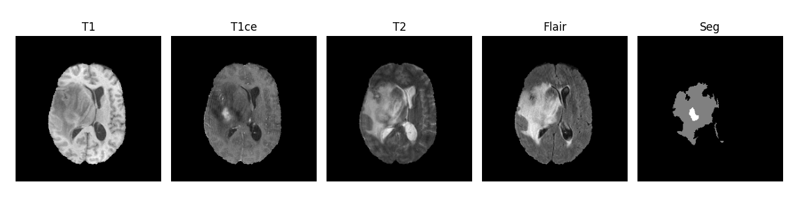

- label
  - 0 : 배경
  - 1 : 전체 종양(Whole tumor)
  - 2 : 핵심 종양(Tumor core)
  - 3 : 조영제 등으로 인해 강조된 종양(enhancing tumor)

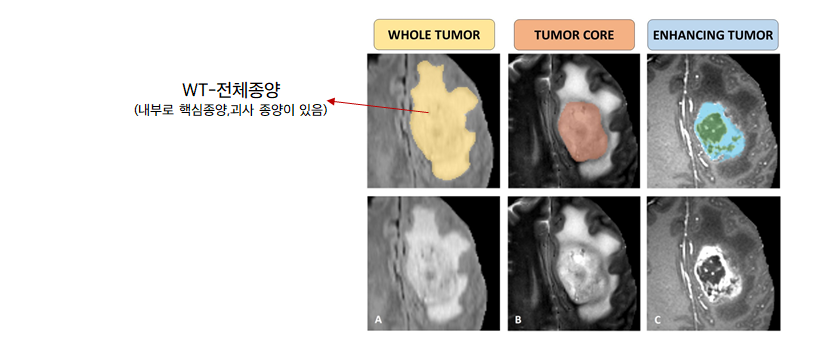

### 데이터 가져오기

In [6]:
train_images =  np.load('/home/nas/data/eunju/npy/z-score/train_images.npy')
val_images =  np.load('/home/nas/data/eunju/npy/z-score/val_images.npy')
test_images =  np.load('/home/nas/data/eunju/npy/z-score/test_images.npy')

train_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/train_labels.npy')
val_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/val_labels.npy')
test_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/test_labels.npy')

train_labels = np.where(train_labels == 4, 3, train_labels)
test_labels = np.where(test_labels == 4, 3, test_labels)
val_labels = np.where(val_labels == 4, 3, val_labels)

print("train_images :",train_images.shape)
print("train_labels :",train_labels.shape)
print("val_images   :",val_images.shape)
print("val_labels   :",val_labels.shape)
print("test_images  :",test_images.shape)
print("test_labels  :",test_labels.shape)

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


In [7]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4)
val_labels = to_categorical(val_labels, num_classes=4)

### 데이터 확인

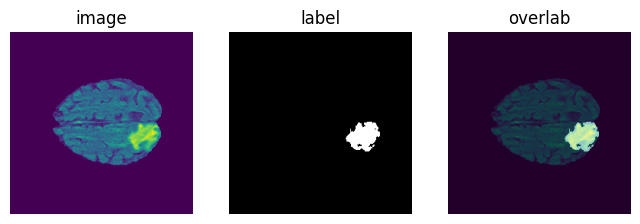

In [8]:
num = 0
plt.figure(figsize=(8,3))
plt.subplot(131); plt.imshow(test_images[num,:,:,3]);plt.title("image"); plt.axis("off")
plt.subplot(132); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("label"); plt.axis("off")

plt.subplot(133); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("overlab"); plt.axis("off")
plt.subplot(133); plt.imshow(test_images[num,:,:,3], alpha=0.5); plt.axis("off");plt.show()

### loss ( dice, bec dice loss)
- 분할에 사용할 수 있는 손실함수들 참고
- https://www.kaggle.com/code/sungjunghwan/loss-function-of-image-segmentation
- https://medium.com/@kimminha1994/loss-functions-for-semantic-segmentation-634a982de702

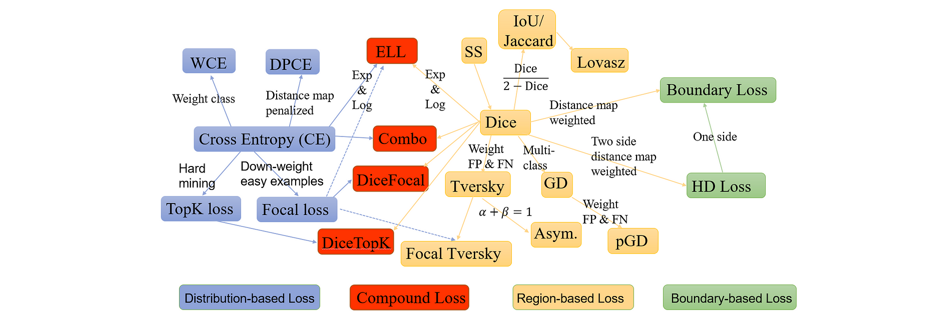

- 여기서는 dice + bce loss를 사용하였음

In [9]:
import numpy as np
from tensorflow import keras

smooth = 1.
dropout_rate = 0.5

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

### 모델 평가 지표

In [10]:
def sensitivity(cm, n):  # recall, True Positive Rate
    sen = []
    for i in range(n):
        tp = cm[i][i]
        sen1 = round((tp / np.sum(cm[i, :])), 4)
        sen.append(sen1)
    return sen

class_name = ["0", "1", "2", "3"]

def specificity(cm, n): # True_negative_rate
    TNR = []
    all = np.sum(cm)
    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        TN = all - FP - FN - TP
        tnr = round((TN/(FP+TN)),4)
        TNR.append(tnr)
    return TNR

def F1_score(cm, n):
    f1_score = []

    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        f1score = round(((2*TP) / (2*TP+FP+FN)),4)
        f1_score.append(f1score)
    return f1_score

def precision(cm, n): # Ppv
    positive_predictive_value = []
    
    for i in range(n):
        TP = cm[i][i]
        TP_FP = np.sum(cm[:,i])
        ppv = round((TP/TP_FP), 4)
        positive_predictive_value.append(ppv)
    return positive_predictive_value

### 시각화

In [11]:
def visual_num(n) :
    num =n
    test_image = test_images[num]
    test_label = test_labels[num]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.argmax(prediction, axis=-1)
# 예측 결과 시각화
    plt.figure(figsize=(9,5))
    plt.subplot(241) ;  plt.imshow(test_image[:,:,0], cmap='gray') ; plt.title('T1');plt.axis('off')
    plt.subplot(242) ;  plt.imshow(test_image[:,:,1], cmap='gray') ; plt.title('T1ce'); plt.axis('off')
    plt.subplot(243) ;  plt.imshow(test_image[:,:,2], cmap='gray') ; plt.title('T2'); plt.axis('off')
    plt.subplot(244) ;  plt.imshow(test_image[:,:,3], cmap='gray') ; plt.title('flair'); plt.axis('off')
    t1 = np.where(test_label == 0, 1,0).astype('uint8')
    t2 = np.where(test_label == 1, 1,0).astype('uint8')
    t3 = np.where(test_label == 2, 1,0).astype('uint8')
    t4 = np.where(test_label == 3, 1,0).astype('uint8')
    plt.subplot(245); plt.imshow(test_label, cmap='gray'); plt.title('Ground Truth');plt.axis('off')
    plt.subplot(2,4,6) ; plt.imshow(prediction, cmap='gray'); plt.title('Predicted');plt.axis('off')
    plt.subplot(2,4,7) ; plt.imshow(abs(test_label-prediction), cmap='gray'); plt.title('GT - pred');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(test_image[:,:,3], cmap='gray'); plt.title('flair overlab');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(abs(test_label-prediction), cmap='jet',alpha=0.5);plt.axis('off')
    t = test_label.flatten()
    p = prediction.flatten()
    matches = t == p
    num_mismatches = len(matches) - np.count_nonzero(matches)
    mismatch_indices = np.where(matches == False)[0]
    print("mismatched labels:", num_mismatches)
    plt.tight_layout();plt.show()

<br>

----

<br>

### 모델 구조
- 구조는 u-net, inception, FPN, Dilated Convolution 등 다양하게 시도해볼 수 있음

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def combined_model(img_rows, img_cols, color_type=1, num_class=1):

    nb_filter = [32,64,128,256,512]

    # Define U-Net structure using the provided function
    def U_Net(img_rows, img_cols, color_type=1, num_class=4):

        nb_filter = [32,64,128,256,512]
        act = 'elu'

        # Handle Dimension Ordering for different backends
        global bn_axis
        if K.image_dim_ordering() == 'tf':
            bn_axis = 3
            img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
        else:
            bn_axis = 1
            img_input = Input(shape=(color_type, img_rows, img_cols), name='main_input')

        conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
        pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

        conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
        pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

        conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
        pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

        conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
        pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

        conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

        up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
        conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
        conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

        up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
        conv3_3 = concatenate([up3_3, conv3_1], name='merge33', axis=bn_axis)
        conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

        up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
        conv2_4 = concatenate([up2_4, conv2_1], name='merge24', axis=bn_axis)
        conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

        up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
        conv1_5 = concatenate([up1_5, conv1_1], name='merge15', axis=bn_axis)
        conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

        unet_output = Conv2D(num_class, (1, 1), activation='softmax', name='output', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

        model = Model(input=img_input, output=unet_output)

        return model

    # Define the direct CNN structure
    inputs = Input(shape=(img_rows, img_cols, color_type))

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder (without bridge, directly connected)
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(pool4), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(num_class, (1, 1), activation='softmax')(conv9)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Define input shape
input_shape = (240, 240, 4)

# Create and compile the combined model
model = combined_model(input_shape[0], input_shape[1], input_shape[2], num_class=4)

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_51 (Conv2D)          (None, 240, 240, 64)         2368      ['input_4[0][0]']             
                                                                                                  
 conv2d_52 (Conv2D)          (None, 240, 240, 64)         36928     ['conv2d_51[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 120, 120, 64)         0         ['conv2d_52[0][0]']           
 ng2D)                                                                                      

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# 얼리스탑 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# 모델 컴파일
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_images, train_labels, epochs=100, batch_size=16, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/100


2024-03-19 14:00:13.959516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-19 14:00:15.444893: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-19 14:00:17.966123: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3b6537c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 14:00:17.966216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-19 14:00:17.966231: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-19 14:00:17.966241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-19 14:00:17.966250: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecuto

245/245 [==============================] - 65s 155ms/step - loss: -0.9516 - accuracy: 0.9818 - val_loss: -0.9722 - val_accuracy: 0.9852
Epoch 2/100
245/245 [==============================] - 25s 103ms/step - loss: -0.9764 - accuracy: 0.9872 - val_loss: -0.9826 - val_accuracy: 0.9901
Epoch 3/100
245/245 [==============================] - 25s 101ms/step - loss: -0.9821 - accuracy: 0.9902 - val_loss: -0.9838 - val_accuracy: 0.9909
Epoch 4/100
245/245 [==============================] - 26s 104ms/step - loss: -0.9860 - accuracy: 0.9922 - val_loss: -0.9848 - val_accuracy: 0.9915
Epoch 5/100
245/245 [==============================] - 26s 104ms/step - loss: -0.9875 - accuracy: 0.9930 - val_loss: -0.9884 - val_accuracy: 0.9936
Epoch 6/100
245/245 [==============================] - 26s 104ms/step - loss: -0.9886 - accuracy: 0.9936 - val_loss: -0.9883 - val_accuracy: 0.9934
Epoch 7/100
245/245 [==============================] - 25s 101ms/step - loss: -0.9892 - accuracy: 0.9940 - val_loss: -0.9901

KeyboardInterrupt: 

In [ ]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

#### test data evaluate

In [ ]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

41/41 [==============================] - 3s 62ms/step


In [15]:
import pandas as pd

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=class_name)
df.loc['Col Ave'] = df.mean()

df

/tmp/ipykernel_26917/3213491271.py:40: RuntimeWarning: invalid value encountered in long_scalars
  ppv = round((TP/TP_FP), 4)


,Sensitivity,Specificity,F1 Score,Precision
0,1.00,0.00,0.989500,0.9793
1,0.00,1.00,0.000000,NaN
2,0.00,1.00,0.000000,NaN
3,0.00,1.00,0.000000,NaN
Col Ave,0.25,0.75,0.247375,0.9793


### 결과 확인
- 정답값과 예측값을 비교해보면 결과가 좋음
- 차이를 확인해보면 대부분 경계에서 오류가 있는 걸 알 수 있음
- 경계값을 잘 맞추도록 수정하면 더 좋은 결과를 얻을 수 있을 것으로 생각됨

1 )
1/1 [==============================] - 0s 257ms/step
mismatched labels: 104


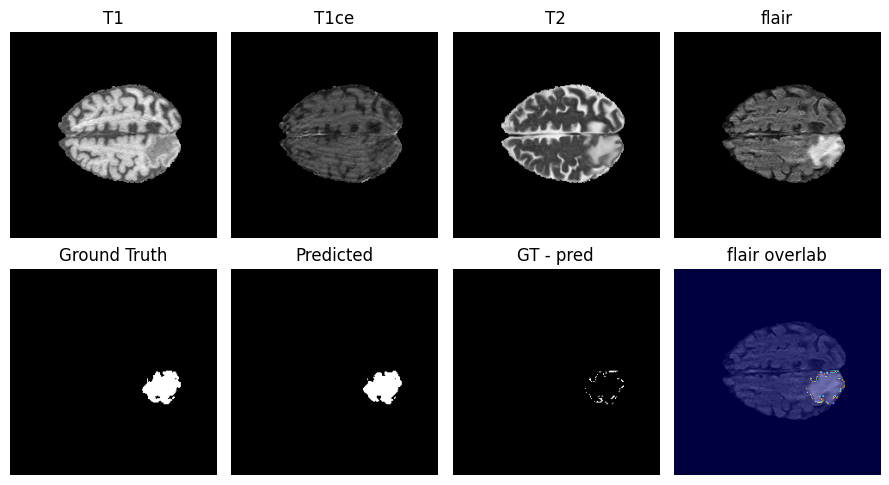

2 )
1/1 [==============================] - 0s 59ms/step
mismatched labels: 162


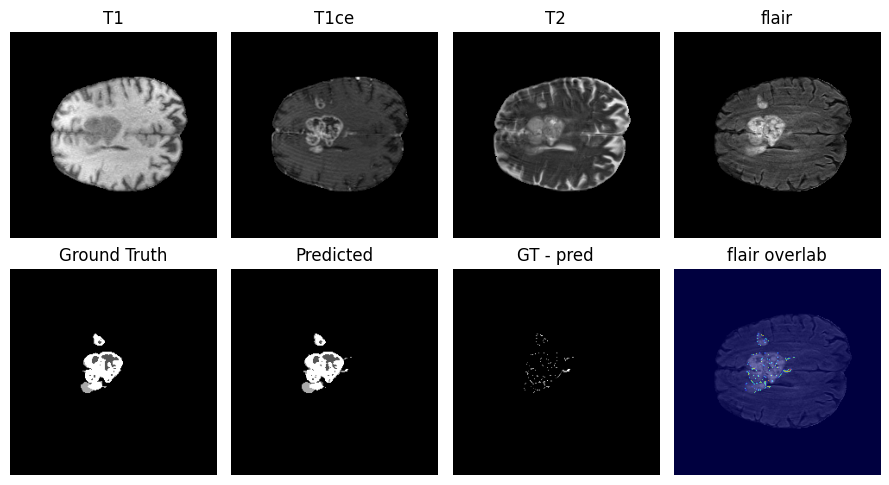

3 )
1/1 [==============================] - 0s 60ms/step
mismatched labels: 207


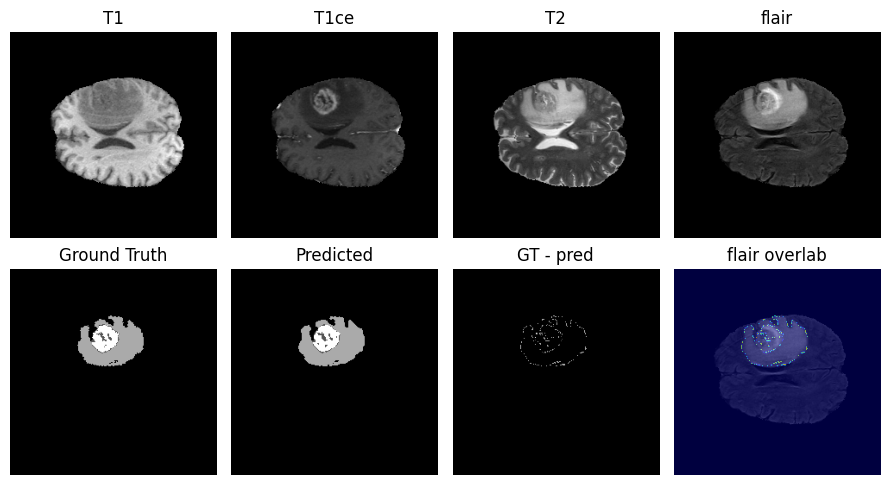

4 )
1/1 [==============================] - 0s 58ms/step
mismatched labels: 47


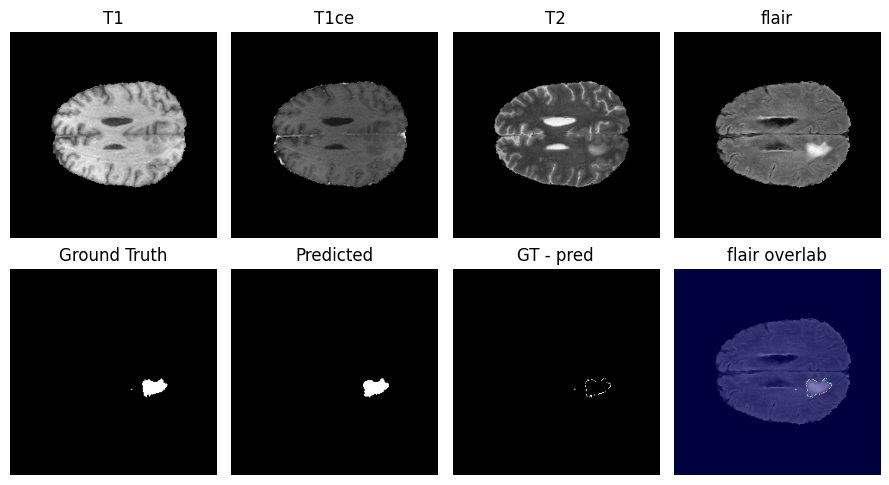

5 )
1/1 [==============================] - 0s 64ms/step
mismatched labels: 185


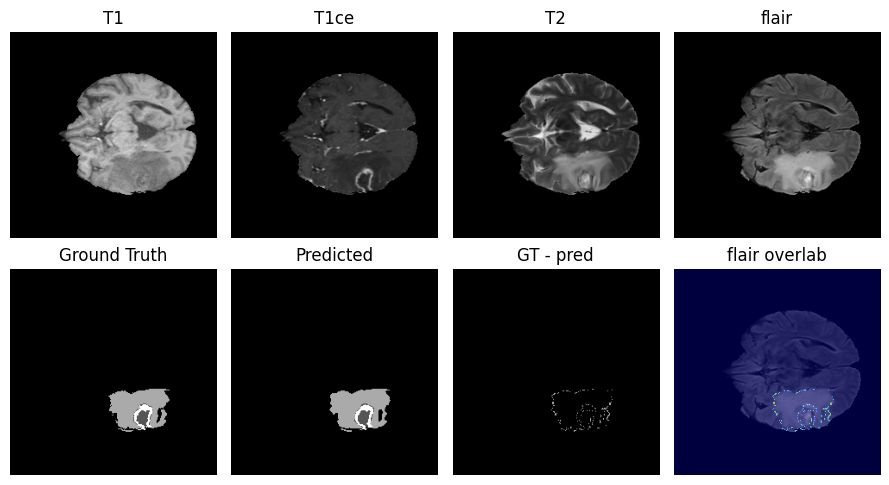

In [32]:
for i in range(5) :
    print(i+1,")")
    visual_num(i)

### 모델 저장

In [15]:
#model.save('../model(1).h5')

<br><br><Br>